In [1]:
import numpy as np
import pandas as pd
import pickle
import torch

/home/graphAttack/anaconda3/envs/gnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Per-node fidelity

In [2]:
# get data from log files
def get_stats(path:str):
    '''
    Extracts information from the output printed in a log-file by main_explain.py. It converts that information into a pandas dataframe.
    '''

    data = list()
    with open(path, 'r') as file:
        lines = file.readlines()
        for i in range(len(lines)):
            if 'Epoch: 0500' in lines[i]:
                # the results are present 3 lines below this line
                # the labels are at the 11th and last postion of the line, once stripped of spaces
                data.append((int(lines[i+3].strip()[11]), int(lines[i+3].strip()[-1])))
    return pd.DataFrame(data, columns=['original', 'new'])

In [3]:
# log files
df_ba_shapes = get_stats("../out/log_bashapes500.txt")
df_cycles_shapes = get_stats("../out/log_cycle500.txt")
df_grids_shapes = get_stats("../out/log_grid500.txt")

In [4]:
# nodes per label
ba_label0 = df_ba_shapes[df_ba_shapes.original == 0].shape[0]
ba_label1 = df_ba_shapes[df_ba_shapes.original == 1].shape[0]
ba_label2 = df_ba_shapes[df_ba_shapes.original == 2].shape[0]
ba_label3 = df_ba_shapes[df_ba_shapes.original == 3].shape[0]
ba_labels = [ba_label0, ba_label1, ba_label2, ba_label3]

cycle_label0 = df_cycles_shapes[df_cycles_shapes.original == 0].shape[0]
cycle_label1 = df_cycles_shapes[df_cycles_shapes.original == 1].shape[0]
cycle_label2 = df_cycles_shapes[df_cycles_shapes.original == 2].shape[0]
cycle_label3 = df_cycles_shapes[df_cycles_shapes.original == 3].shape[0]
cycle_labels = [cycle_label0, cycle_label1, cycle_label2, cycle_label3]

grid_label0 = df_grids_shapes[df_grids_shapes.original == 0].shape[0]
grid_label1 = df_grids_shapes[df_grids_shapes.original == 1].shape[0]
grid_label2 = df_grids_shapes[df_grids_shapes.original == 2].shape[0]
grid_label3 = df_grids_shapes[df_grids_shapes.original == 3].shape[0]
grid_labels = [grid_label0, grid_label1, grid_label2, grid_label3]

In [5]:
# get pickled counterfactuals
cf_pickle_filepaths = [
    "../results/syn1/SGD/syn1_cf_examples_lr0.01_beta0.5_mom0.9_epochs500",
    "../results/syn4/SGD/syn4_cf_examples_lr0.1_beta0.5_mom0.0_epochs500",
    "../results/syn5/SGD/syn5_cf_examples_lr0.1_beta0.5_mom0.0_epochs500"
]
with open(cf_pickle_filepaths[0], "rb") as f0, open(cf_pickle_filepaths[1], "rb") as f1, open(cf_pickle_filepaths[2], "rb") as f2: 
    cf_ba_shapes = pickle.load(f0)
    cf_cycles_shapes = pickle.load(f1)
    cf_grids_shapes = pickle.load(f2)

In [28]:
for dataset, labels in zip([cf_ba_shapes, cf_cycles_shapes, cf_grids_shapes], [ba_labels, cycle_labels, grid_labels]):
    label0, label1, label2, label3 = 0, 0, 0, 0
    temp = list()
    for i in dataset:
        if len(i) == 0:
            continue
        elif i[0][4] == 0 and i[0][6] != 0:
            label0 += 1
        elif i[0][4] == 1 and i[0][6] != 1:
            label1 += 1
        elif i[0][4] == 2 and i[0][6] != 2:
            label2 += 1
        elif i[0][4] == 3 and i[0][6] != 3:
            label3 += 1
    
    print(f"Label-0: {label0}/{labels[0]}\
        \nLabel-1: {label1}/{labels[1]}\
        \nLabel-2: {label2}/{labels[2]}\
        \nLabel-3: {label3}/{labels[3]}")
    
    print(f"Total cfs found: {sum([label0, label1, label2, label3])}/{len(dataset)}")
    print(f"Total fidelity: {1 - sum([label0, label1, label2, label3])/len(dataset)}")
    print()

Label-0: 14/62        
Label-1: 30/30        
Label-2: 2/30        
Label-3: 18/18
Total cfs found: 64/140
Total fidelity: 0.5428571428571429

Label-0: 94/94        
Label-1: 45/81        
Label-2: 0/0        
Label-3: 0/0
Total cfs found: 139/175
Total fidelity: 0.20571428571428574

Label-0: 95/97        
Label-1: 135/150        
Label-2: 0/0        
Label-3: 0/0
Total cfs found: 230/247
Total fidelity: 0.06882591093117407



## Total Fidelity

In [91]:
print(f"""
    Counterfactuals found:
    BA-shapes: {df_ba_shapes[(df_ba_shapes.original != df_ba_shapes.new)].shape[0]}/{df_ba_shapes.shape[0]} = {1 - df_ba_shapes[(df_ba_shapes.original != df_ba_shapes.new)].shape[0]/df_ba_shapes.shape[0]}
    Cycles: {df_cycles_shapes[(df_cycles_shapes.original != df_cycles_shapes.new)].shape[0]}/{df_cycles_shapes.shape[0]} = {1 - df_cycles_shapes[(df_cycles_shapes.original != df_cycles_shapes.new)].shape[0]/df_cycles_shapes.shape[0]}
    Grids: {df_grids_shapes[(df_grids_shapes.original != df_grids_shapes.new)].shape[0]}/{df_grids_shapes.shape[0]} = {1 - df_grids_shapes[(df_grids_shapes.original != df_grids_shapes.new)].shape[0]/df_grids_shapes.shape[0]}
    """
)


    Counterfactuals found:
    BA-shapes: 51/140 = 0.6357142857142857
    Cycles: 139/175 = 0.20571428571428574
    Grids: 230/247 = 0.06882591093117407
    


## Nodes per label

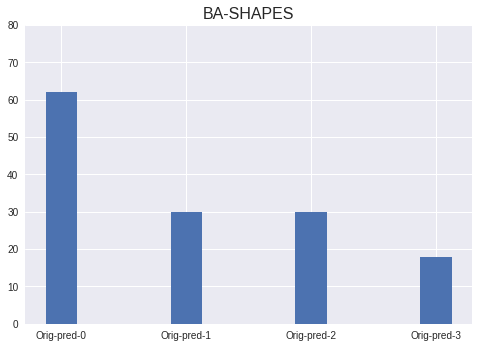

In [70]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import rc

plt.bar(
    ["Orig-pred-0", "Orig-pred-1", "Orig-pred-2", "Orig-pred-3"],
    [ba_label0, ba_label1, ba_label2, ba_label3],
    width=[0.25, 0.25, 0.25, 0.25]
)
plt.title("BA-SHAPES", fontdict={"size":16})
plt.ylim(0, 80)
plt.show()

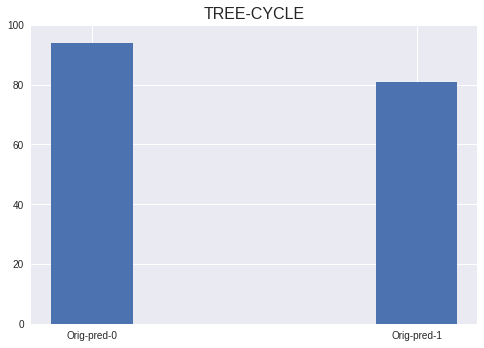

In [69]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import rc

plt.bar(
    ["Orig-pred-0", "Orig-pred-1"],
    [cycle_label0, cycle_label1],
    width=[0.25, 0.25]
)
plt.title("TREE-CYCLE", fontdict={"size":16})
plt.ylim(0, 100)
plt.show()

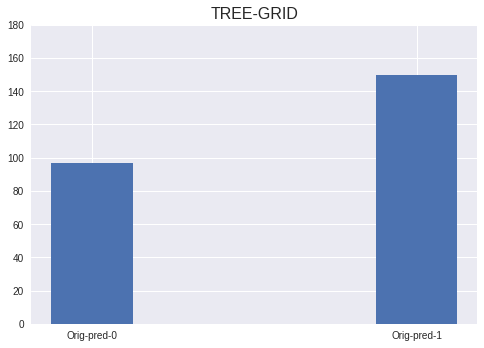

In [66]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import rc

plt.bar(
    ["Orig-pred-0", "Orig-pred-1"],
    [grid_label0, grid_label1],
    width=[0.25, 0.25]
)
plt.title("TREE-GRID", fontdict={"size":16})
plt.ylim(0, 180)
plt.show()